In [16]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

plt.rcParams["font.family"] = "Arial"

from utils.data_processing import process_string

## Load Data

In [17]:
df_food_filtered_agg = pd.read_csv("./data/df_food_filtered_agg.csv")

## Compute minimum days using D method

In [18]:
def compute_minimum_days_D_method(
    data, subject_col, day_col, value_col, r_values=[0.8, 0.85, 0.9]
):
    """
    Compute the minimum number of days required for reliable dietary assessment.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    subject_col (str): Column name for subjects.
    day_col (str): Column name for days.
    value_col (str): Column name for values.
    r_values (list): List of r values to calculate D for.

    Returns:
    dict: Dictionary with r values as keys and minimum days (D) as values.
    """
    # Fit a Linear Mixed Model (LMM)
    model = mixedlm(f"{value_col} ~ {day_col}", data, groups=data[subject_col])
    result = model.fit()

    # Extract variance components
    variance_components = result.cov_re
    residual_variance = result.scale

    # Check if either variance is very close to zero
    is_on_boundary = (variance_components.iloc[0, 0] < 1e-5) or (
        residual_variance < 1e-5
    )

    # Calculate intra and inter-individual variances
    inter_individual_variance = variance_components.iloc[0, 0]
    intra_individual_variance = residual_variance

    # Mean of the values
    mean_value = data[value_col].mean()

    # Calculate CVw and CVb
    CVw = (np.sqrt(intra_individual_variance) / mean_value) * 100
    CVb = (np.sqrt(inter_individual_variance) / mean_value) * 100

    # Variance Ratio
    variance_ratio = (CVw**2) / (CVb**2)

    # Function to calculate D for a given r
    def calculate_D(r, variance_ratio):
        return (r**2 / (1 - r**2)) * variance_ratio

    # Calculate D for each r
    # Ds = {r: calculate_D(r, variance_ratio) for r in r_values}
    Ds = [calculate_D(r, variance_ratio) for r in r_values]

    return {
        "CVw": CVw,
        "CVb": CVb,
        "Variance Ratio": variance_ratio,
        "Minimum Days": Ds,
        "converged": result.converged,
        "is_on_boundary": is_on_boundary,
    }

In [19]:
res_min_days_D_method = {}
res_variance_ratio_D_method = {}
res_CVw_D_method = {}
res_CVb_D_method = {}

res_CV_D_method = []

## ignore these columns since they are similar to other columns or not converging
cols_to_ignore = [
    "subject_key",
    "day_of_week",
    "alcohol_fg_eaten",
    "others_fg_eaten",
    "energy_kj_eaten",
    "vegetables_fruits",
    "sweets_salty_snacks_alcohol",
    "dairy_products_meat_fish_eggs_tofu",
    "sugary_fg_eaten",
    "oils_fats_nuts",
    "vitamin_b1_eaten",
    "fatty_acids_monounsaturated_eaten",
]

for col in tqdm(df_food_filtered_agg.columns):
    if col in cols_to_ignore:
        continue
    # res_min_days_D_method[col], res_variance_ratio_D_method[col] = compute_minimum_days_D_method(df_food_filtered_agg, 'subject_key', 'day_of_week', col)
    res_D_method = compute_minimum_days_D_method(
        df_food_filtered_agg, "subject_key", "day_of_week", col
    )
    res_min_days_D_method[col] = res_D_method["Minimum Days"]
    res_CV_D_method.append(
        {
            "feature": col,
            "converged": res_D_method["converged"],
            "is_on_boundary": res_D_method["is_on_boundary"],
            "Variance Ratio": res_D_method["Variance Ratio"],
            "CVw": res_D_method["CVw"],
            "CVb": res_D_method["CVb"],
            "r=0.8": res_D_method["Minimum Days"][0],
            "r=0.85": res_D_method["Minimum Days"][1],
            "r=0.9": res_D_method["Minimum Days"][2],
        }
    )

## Creating minimum days DataFrame for D method
# df_min_days_D_method = pd.DataFrame(res_min_days_D_method, index=['r=0.8', 'r=0.85', 'r=0.9']).T

df_CV_metrics_D_method = pd.DataFrame(res_CV_D_method).sort_values(
    "Variance Ratio", ascending=True
)
# df_CV_metrics_D_method = df_CV_metrics_D_method.merge(df_min_days_D_method, left_on='feature', right_index=True)

df_CV_metrics_D_method.head()

 19%|█▊        | 10/54 [00:03<00:19,  2.27it/s]/Users/rohansingh/miniconda3/envs/mindays/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 30%|██▉       | 16/54 [00:06<00:17,  2.15it/s]/Users/rohansingh/miniconda3/envs/mindays/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 31%|███▏      | 17/54 [00:06<00:17,  2.14it/s]/Users/rohansingh/miniconda3/envs/mindays/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 33%|███▎      | 18/54 [00:07<00:17,  2.04it/s]/Users/rohansingh/miniconda3/envs/mindays/lib/python3.12/site-packages/statsmodels/regression/mixe

,feature,converged,is_on_boundary,Variance Ratio,CVw,CVb,r=0.8,r=0.85,r=0.9
40,water_fg_eaten,True,False,0.256253,36.843898,72.783245,0.455560,0.667180,1.092445
28,non_alcoholic_beverages,True,False,0.351575,33.903777,57.179298,0.625023,0.915363,1.498822
35,coffee_fg_eaten,True,False,0.368732,47.601760,78.391283,0.655523,0.960031,1.571961
0,eaten_quantity_in_gram,True,False,0.388582,19.689309,31.585602,0.690812,1.011713,1.656586
39,vegan_fg_eaten,True,False,0.663819,121.057169,148.581774,1.180123,1.728323,2.829967


In [20]:
df_CV_metrics_D_method[df_CV_metrics_D_method["is_on_boundary"] == True]

,feature,converged,is_on_boundary,Variance Ratio,CVw,CVb,r=0.8,r=0.85,r=0.9
12,folate_eaten,True,True,1.144903,36.198024,33.829888,2.035383,2.980873,4.880901
22,vitamin_b12_eaten,True,True,1.439841,126.700153,105.589274,2.559718,3.748776,6.138271
7,beta_carotene_eaten,True,True,2.056862,84.999377,59.267033,3.656643,5.355253,8.768727
27,zinc_eaten,True,True,2.442729,46.180106,29.547264,4.342629,6.359898,10.413740
26,vitamin_d_eaten,True,True,3.590139,83.495394,44.066332,6.382469,9.347298,15.305328


In [21]:
print(
    df_CV_metrics_D_method[df_CV_metrics_D_method["converged"] == False][
        "feature"
    ].values
)

df_CV_metrics_D_method = df_CV_metrics_D_method[
    df_CV_metrics_D_method["converged"] == True
]

[]


## Visualize the minimum days estimation using CV method

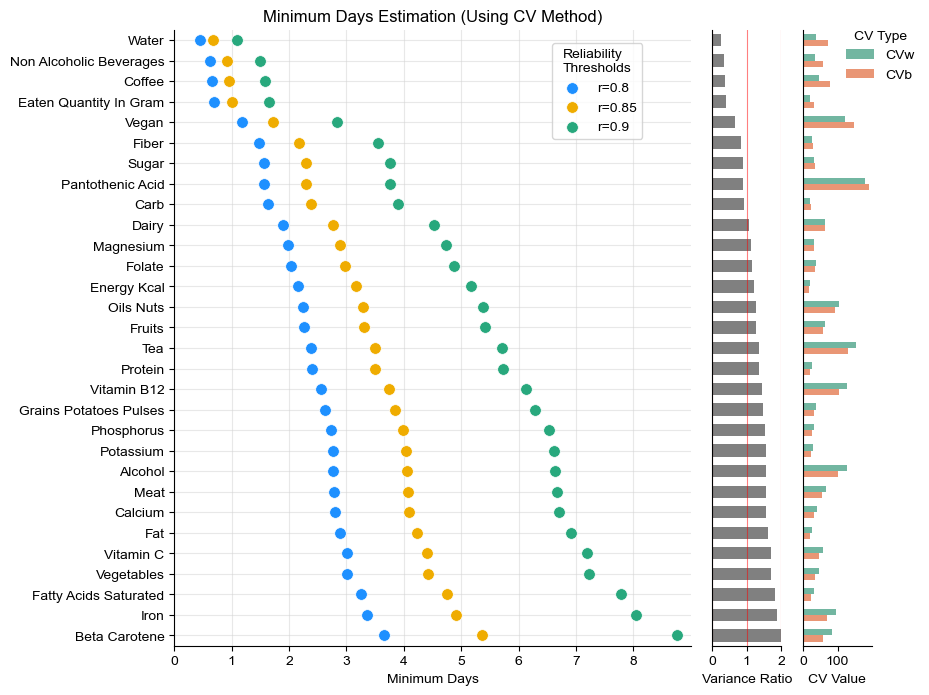

In [22]:
# Create a figure with specified size
fig = plt.figure(figsize=(9, 8))
gs = GridSpec(1, 3, width_ratios=[6, 0.8, 0.8], wspace=0.1)

# Create the first subplot (left side)
ax1 = fig.add_subplot(gs[0, 0])

topn = 30

plot_df_min_days_D_method = df_CV_metrics_D_method[:topn].copy()
plot_df_min_days_D_method.loc[:, "feature"] = plot_df_min_days_D_method["feature"].map(
    lambda x: process_string(x, ignore_vars=[], newLineSep=6)
)

s_size = 70
sns.scatterplot(
    data=plot_df_min_days_D_method,
    x="r=0.8",
    y="feature",
    color="dodgerblue",
    s=s_size,
    zorder=2,
    ax=ax1,
    linewidth=0.5,
)
sns.scatterplot(
    data=plot_df_min_days_D_method,
    x="r=0.85",
    y="feature",
    color="#EFAC00",
    s=s_size,
    zorder=2,
    ax=ax1,
    linewidth=0.5,
)
sns.scatterplot(
    data=plot_df_min_days_D_method,
    x="r=0.9",
    y="feature",
    color="#28A87D",
    s=s_size,
    zorder=2,
    ax=ax1,
    linewidth=0.5,
)

ax1.set_xlabel("Minimum Days")
ax1.set_ylabel("")
ax1.set_title("Minimum Days Estimation (Using CV Method)")
ax1.yaxis.grid(True, linestyle="-", which="major", color="lightgrey", alpha=0.5)
ax1.xaxis.grid(True, linestyle="-", which="major", color="lightgrey", alpha=0.5)
ax1.legend(
    ["r=0.8", "r=0.85", "r=0.9"],
    loc="upper right",
    title="Reliability\nThresholds",
    bbox_to_anchor=(0.92, 0.99),
    alignment="center",
)

## make x ticks integers
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
## limit the x-axis ticks up to 9
ax1.set_xlim(0, 9)
## hide the last x-axis tick
ax1.set_xticks(ax1.get_xticks()[:-1])

sns.despine(ax=ax1)

########################################################################################## Variance ratio

# plot_CV_df = df_CV_metrics_D_method.reset_index(names='feature')
# plot_CV_df['feature'] = plot_CV_df['feature'].map(lambda x: process_string(x, ignore_vars=[], newLineSep=6))
# plot_CV_df = plot_CV_df[plot_CV_df['feature'].isin(plot_df_min_days_D_method['feature'])]
# ## order the plot_CV_df based on the order of plot_df_min_days_D_method
# plot_CV_df['feature'] = pd.Categorical(plot_CV_df['feature'], categories=plot_df_min_days_D_method['feature'], ordered=True)
# plot_CV_df = plot_CV_df.sort_values('feature')
# print('plot_CV_df.shape:',plot_CV_df.shape)

# Create the second subplot (right side)
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

sns.barplot(
    data=plot_df_min_days_D_method,
    y="feature",
    x="Variance Ratio",  # hue='Variance Ratio',
    color="grey",
    legend=False,  # palette='autumn',
    width=0.6,
    zorder=0,
    ax=ax2,
)

ax2.set_xlabel("Variance Ratio")
ax2.set_ylabel("")  # Remove y-axis label to avoid redundancy
# ax2.set_title('Variance Ratio')

## grid lines
ax2.xaxis.grid(True, linestyle="-", which="major", color="red", alpha=0.5)

# hide the y-axis tick labels
ax2.tick_params(axis="y", which="both", left=False, labelleft=False)
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

ax2.set_xlim(0, 2)
sns.despine(ax=ax2)

########################################################################################## CVb

ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)


plot_df_min_days_D_method_melted = plot_df_min_days_D_method.melt(
    id_vars=["feature", "Variance Ratio", "r=0.8", "r=0.85", "r=0.9"],
    value_vars=["CVw", "CVb"],
    var_name="CV_Type",
    value_name="CV_Value",
)
sns.barplot(
    data=plot_df_min_days_D_method_melted,
    y="feature",
    x="CV_Value",
    palette="Set2",
    hue="CV_Type",
    legend=True,  # palette='summer',
    width=0.6,
    zorder=0,
    ax=ax3,
)

## move the legend outside the plot and remove border
ax3.legend(
    loc="upper right",
    bbox_to_anchor=(1.8, 1.02),
    title="CV Type",
    frameon=False,
    alignment="center",
)

ax3.set_xlabel("CV Value")
ax3.set_ylabel("")  # Remove y-axis label to avoid redundancy

# hide the y-axis tick labels
ax3.tick_params(axis="y", which="both", left=False, labelleft=False)
# ax3.set_xlim(0, 100)
# ax3.set_xticks([0, 50, 100])
sns.despine(ax=ax3)

# plt.savefig("./figures/CV_method.png", dpi=300)